# FACIAL KEYPOINTS DETECTION

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

**Importing the libraraies**

In [6]:
import numpy as np
import pandas as pd
import random
import os
import pickle as pkl 
import matplotlib.pyplot as plt

from src.data_preparation import separate_data_with_missing_values
from src.utils import *
from src.utils import visualize_random_indexed_image
import src.config.data_preparation_config as config

pd.options.mode.chained_assignment = None 

**Building a Client for  Kaggle API**

Follow the instructions in https://github.com/Kaggle/kaggle-api to download Kaggle.json file


In [23]:
# Mine are an example and the key is expired. You should use yours instead
os.environ['KAGGLE_USERNAME'] =  config.KAGGLE_USERNAME # username from the json file
os.environ['KAGGLE_KEY'] = config.KAGGLE_KEY # key from the json file

In [24]:
#Crearting a Client to host the Kaggle API
!pip install -q kaggle

In [25]:
# Improting the dataet using Kaggle API provided for the Facial Keypoint Detection
!kaggle competitions download -c facial-keypoints-detection
!unzip facial-keypoints-detection.zip -d facial-keypoints-detection

401 - Unauthorized
Archive:  facial-keypoints-detection.zip
replace facial-keypoints-detection/IdLookupTable.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


## PART 1 - Dataset Preparation

### Part 1.1 EDA and Feature Engineering
This is the data analaysis of our dataset whilist descovering the missing values, train a model for each feature to use it to replace the missing features.


###### **Importing the Data Frames using Pandas**

In [37]:
main_df = pd.read_csv('facial-keypoints-detection/training.zip', compression='zip', header=0, sep=',', quotechar='"')

In [38]:
main_df.head(1)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...


###### **Transform image string into 2D array**
Since values for the image is given as space separated string, we will need to separate the values using ' ' as separator<br>
Then convert this into numpy array using np.fromstring and convert the obtained 1D array into 2D array of shape (96,96)

In [39]:
# transform
main_df['Image'] = main_df['Image'].apply(lambda x: np.fromstring(x, dtype= int, sep = ' ').reshape(96,96))

In [40]:
# Let's obtain the shape of the resized image
main_df['Image'][1].shape

(96, 96)

##### **Visualize some images with face landmarks**

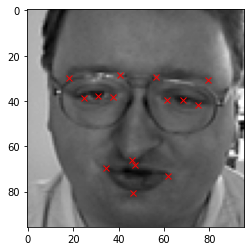

In [19]:
visualize_random_indexed_image(main_df, i=-1, image_path=None)

##### **Checking for missing values**

In [20]:
# checking for missing values
main_df.isnull().any().value_counts()

True     28
False     3
dtype: int64

So there are missing values in 28 columns. Lets see which columns

In [21]:
display(main_df.isnull().sum())

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

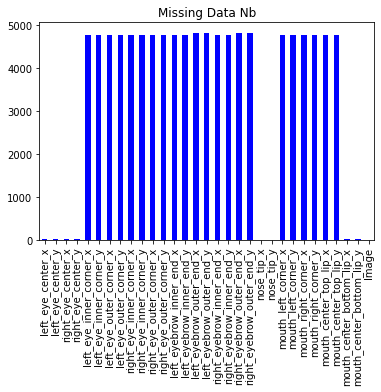

In [22]:
main_df.isnull().sum().plot(kind='bar',color = 'blue')
plt.title("Missing Data Nb")
plt.savefig(config.missing_data_save_image_path, bbox_inches = "tight")
plt.show()

In [23]:
# count the number of rows with missing values
main_df.isnull().any(axis=1).sum() 

4909

The number of data is 7049 and 4909 rows are with missing values which means more than the half. Thus we cannot drop them.

**Visualize how many missing values per rows**

In [24]:
df_missing = main_df[main_df.isnull().any(axis=1)]
df_missing.shape

(4909, 31)

In [25]:
df_missing["missing_values_count"] = df_missing.isnull().sum(axis=1)

In [26]:
df_missing.groupby(["missing_values_count"])[["Image"]].count()

,Image
missing_values_count,
2,87
4,28
6,9
8,8
10,3
12,5
14,2
20,2
22,4755


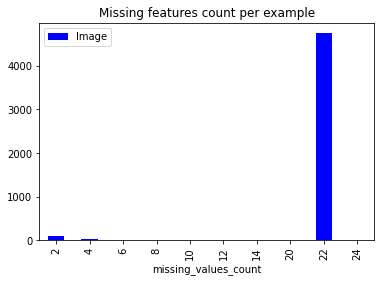

In [27]:
fig = df_missing.groupby(["missing_values_count"])[["Image"]].count().plot(kind='bar',color = 'blue', title="Missing features count per example").get_figure()
fig.savefig(config.missing_values_count_save_image_path)

#### **Dealing with missing values**


**Prepare datasets to train a model for each feature inorder to use it to replace the missing values**

Inorder to fill the missing values, we will train a prediction model for each feature except the nose as it doesn't have any missing value. Thus we shall train 14 model. First we will prepare the dataset for each feature.
<br> We will build a dictionary of dataframes that contain the dataset for each feature (separating features from each other)

In [28]:
df_nose = main_df[["nose_tip_x","nose_tip_y","Image"]].reset_index()

In [29]:
save_to_pickle(df_nose, config.nose_tip_data_save_path)

In [30]:
df_nose.head()

,index,nose_tip_x,nose_tip_y,Image
0,0,44.420571,57.066803,"[[238, 236, 237, 238, 240, 240, 239, 241, 241,..."
1,1,48.206298,55.660936,"[[219, 215, 204, 196, 204, 211, 212, 200, 180,..."
2,2,47.557263,53.538947,"[[144, 142, 159, 180, 188, 188, 184, 180, 167,..."
3,3,51.885078,54.166539,"[[193, 192, 193, 194, 194, 194, 193, 192, 168,..."
4,4,43.299534,64.889521,"[[147, 148, 160, 196, 215, 214, 216, 217, 219,..."


In [35]:
dic_missing_data, dic_non_missing_data = separate_data_with_missing_values(main_df)

Lets see the number of non null examples for each feature pf the 14 feature.<br>This will be the size of the dataset that we will remain with for each feature.

In [36]:
#  View an example.
dic_non_missing_data["right_eyebrow_outer_end"].head()

,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,Image
0,16.356379,29.647471,"[[238, 236, 237, 238, 240, 240, 239, 241, 241,..."
1,16.865362,27.058860,"[[219, 215, 204, 196, 204, 211, 212, 200, 180,..."
2,16.791158,32.087116,"[[144, 142, 159, 180, 188, 188, 184, 180, 167,..."
3,20.458017,29.909343,"[[193, 192, 193, 194, 194, 194, 193, 192, 168,..."
4,15.925870,30.672177,"[[147, 148, 160, 196, 215, 214, 216, 217, 219,..."


In [37]:
save_to_pickle(dic_non_missing_data, config.dic_non_missing_data_save_path)
save_to_pickle(dic_missing_data, config.dic_missing_data_save_path)

save the dictionaries in pickle format